In [1]:
# Load the dataset
import pandas as pd

df = pd.read_csv('../datasets/csv/HaLT-SubjectA-160223-6St-LRHandLegTongue_experiment_0.csv')
df2 = pd.read_csv('../datasets/csv/HaLT-SubjectA-160223-6St-LRHandLegTongue_experiment_1.csv')
df3 = pd.read_csv('../datasets/csv/HaLT-SubjectA-160223-6St-LRHandLegTongue_experiment_2.csv')
df4 = pd.read_csv('../datasets/csv/HaLT-SubjectA-160308-6St-LRHandLegTongue_experiment_0.csv')
df5 = pd.read_csv('../datasets/csv/HaLT-SubjectA-160308-6St-LRHandLegTongue_experiment_1.csv')

df = df.sort_values(by=df.columns[0])
df = df.drop(df.columns[0], axis=1)

df2 = df2.sort_values(by=df2.columns[0])
df2 = df2.drop(df2.columns[0], axis=1)
df3 = df3.sort_values(by=df3.columns[0])
df3 = df3.drop(df3.columns[0], axis=1)
df4 = df4.sort_values(by=df4.columns[0])
df4 = df4.drop(df4.columns[0], axis=1)
df5 = df5.sort_values(by=df5.columns[0])
df5 = df5.drop(df5.columns[0], axis=1)

df = pd.concat([df, df2, df3, df4, df5])

valid_df = pd.read_csv('../datasets/csv/HaLT-SubjectA-160310-6St-LRHandLegTongue_experiment_0.csv')
valid_df = valid_df.sort_values(by=valid_df.columns[0])
valid_df = valid_df.drop(valid_df.columns[0], axis=1)

df.head()

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T3,T4,T5,T6,Fz,Cz,Pz,X5,Marker
0,5.96,9.27,-2.47,1.62,0.37,-0.31,-1.97,-0.18,-1.64,-0.18,...,5.36,2.56,3.60,2.33,0.46,0.05,-0.90,0.60,0.10,0
1,-0.56,10.45,1.10,1.87,1.37,-1.32,0.79,1.26,0.60,1.51,...,-0.59,0.25,-1.22,1.91,-0.54,4.41,4.49,2.98,-0.03,0
2,-3.60,9.30,-1.98,5.98,-1.81,2.29,-5.11,-0.82,-6.07,-0.80,...,6.84,-5.01,2.26,-5.23,-1.18,2.42,1.40,-0.97,-0.00,0
3,-8.21,6.74,-3.58,0.48,-0.41,0.09,-0.43,-0.95,-1.10,-0.58,...,2.36,-3.13,0.71,-0.90,-1.48,-0.77,0.27,-0.30,-0.39,0
4,-2.05,12.03,0.54,-3.85,2.16,-3.58,0.93,-0.71,1.06,-0.66,...,0.28,2.53,-3.02,1.89,-1.27,-1.71,-0.82,-1.59,-0.31,0


In [2]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# import torch.utils.data as data
# import numpy as np

# # Define dataloaders
# BATCH_SIZE = 64
# classes = np.unique(df['Marker'])
# # features = df[['Cz', 'C3', 'A1', 'F3', 'P3']]
# features = df.drop(['Marker'], axis=1)

# # use 20% of training data for validation
# train_set_size = int(len(df) * 0.8)
# valid_set_size = len(df) - train_set_size

# train_set = features[:][:train_set_size]
# valid_set = features[:][train_set_size:]

# train_data_y = torch.tensor(df['Marker'][:train_set_size].values).type(torch.LongTensor) 
# validation_data_y = torch.tensor(df['Marker'][train_set_size:].values).type(torch.LongTensor) 

# train_data_x = torch.tensor(train_set.values).type(torch.LongTensor) 
# validation_data_x = torch.tensor(valid_set.values).type(torch.LongTensor) 

# train_tensor = data.TensorDataset(train_data_x, train_data_y)
# validation_tensor = data.TensorDataset(validation_data_x, validation_data_y)

# train_loader = data.DataLoader(train_tensor, batch_size=BATCH_SIZE, num_workers=8)
# validation_loader = data.DataLoader(validation_tensor, batch_size=BATCH_SIZE, num_workers=8)



In [4]:
import torch.utils.data as data
import numpy as np

# Define dataloaders
BATCH_SIZE = 64

classes = np.unique(df['Marker'])
# features = df[['Cz', 'C3', 'A1', 'F3', 'P3']]
features = df.drop(['Marker'], axis=1)
valid_features = valid_df.drop(['Marker'], axis=1)

train_data_y = torch.tensor(df['Marker'].values).type(torch.LongTensor)
validation_data_y = torch.tensor(valid_df['Marker'].values).type(torch.LongTensor)

train_data_x = torch.tensor(features.values).type(torch.LongTensor) 
validation_data_x = torch.tensor(valid_features.values).type(torch.LongTensor)

train_tensor = data.TensorDataset(train_data_x, train_data_y)
validation_tensor = data.TensorDataset(validation_data_x, validation_data_y)

train_loader = data.DataLoader(train_tensor, batch_size=BATCH_SIZE, num_workers=8)
validation_loader = data.DataLoader(validation_tensor, batch_size=BATCH_SIZE, num_workers=8)

In [5]:
# Train NN
import datetime

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    total_start = datetime.datetime.now()
    correct, train_loss = 0, 0
     
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred, _ = model.liquid.forward(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        pred = model.softmax(pred)
        correct += torch.eq(torch.argmax(pred, dim=1), y).type(torch.float).sum().item()
        train_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print(f'Training time: {(datetime.datetime.now() - total_start).total_seconds()}')
    correct /= size
    return train_loss / batch, correct


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred, _ = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += torch.eq(torch.argmax(pred, dim=1), y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

    return test_loss, correct


In [6]:
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import CfC

class LiquidBlock(nn.Module):
    def __init__(self, units=20, out_features=10, in_features=5):
        super().__init__()
        wiring = AutoNCP(units, out_features)
        self.units = units
        self.liquid = CfC(in_features, wiring, return_sequences=True, batch_first=True)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, state=None):
        x, hx = self.liquid.forward(input=x, hx=state)
        return self.softmax(x), hx

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3
model_units = 125
decay_rate = 0.95

model = LiquidBlock(units=model_units, out_features=len(classes), in_features=len(features.columns)).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate, verbose=True)

epochs = 40
history = []

print(f'MODEL PARAMETERS: {count_parameters(model)}')

Adjusting learning rate of group 0 to 1.0000e-03.
MODEL PARAMETERS: 50608


In [8]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(validation_loader, model, loss_fn)
    lr_scheduler.step()
    epoch = {'val': {'loss': test_loss, 'acc': test_acc}, 'train': {'loss': train_loss, 'acc': train_acc}}
    history.append(epoch)

print("Done!")

Epoch 1
-------------------------------
loss: 1.979363  [   64/467150]
loss: 1.852247  [ 6464/467150]
loss: 1.895211  [12864/467150]
loss: 1.596456  [19264/467150]
loss: 1.713772  [25664/467150]
loss: 2.166567  [32064/467150]
loss: 1.419109  [38464/467150]
loss: 1.882632  [44864/467150]
loss: 1.161677  [51264/467150]
loss: 2.336313  [57664/467150]
loss: 1.422207  [64064/467150]
loss: 1.292799  [70464/467150]
loss: 2.004046  [76864/467150]
loss: 1.370682  [83264/467150]
loss: 1.443240  [89664/467150]
loss: 1.595247  [96064/467150]
loss: 1.832795  [102464/467150]
loss: 1.250398  [108864/467150]
loss: 1.563128  [115264/467150]
loss: 2.411667  [121664/467150]
loss: 1.613313  [128064/467150]
loss: 1.770128  [134464/467150]
loss: 2.166254  [140864/467150]
loss: 1.727403  [147264/467150]
loss: 1.852602  [153664/467150]
loss: 1.555224  [160064/467150]
loss: 1.812465  [166464/467150]
loss: 1.545978  [172864/467150]
loss: 1.154088  [179264/467150]
loss: 1.480724  [185664/467150]
loss: 1.134314  

In [9]:
print(history)

import json

train_log = {
    'decay_rate': decay_rate,
    'inputs': model.liquid.input_size,
    'batch_size': BATCH_SIZE,
    'learning_rate': learning_rate,
    'units': model_units,
    'num_epochs': epochs,
    'epochs': history,
    'train_samples': len(df),
}

log_name = f'../log/pytorch/history_{datetime.datetime.timestamp(datetime.datetime.now())}.json'

with open(log_name, 'w', encoding='utf-8') as f:
    json.dump(train_log, f, ensure_ascii=False, indent=4)



[{'val': {'loss': 1.8707616064940926, 'acc': 0.3593954047659068}, 'train': {'loss': 1.7265987349039953, 'acc': 0.3152798886867173}}, {'val': {'loss': 1.8557786336114723, 'acc': 0.37831163289846265}, 'train': {'loss': 1.639627386436248, 'acc': 0.3654993042919833}}, {'val': {'loss': 1.8506451017901955, 'acc': 0.3948229270374058}, 'train': {'loss': 1.6119926360098038, 'acc': 0.3826180027828321}}, {'val': {'loss': 1.848939051008895, 'acc': 0.40228339431866666}, 'train': {'loss': 1.597396140213551, 'acc': 0.39328909343893825}}, {'val': {'loss': 1.850152028800043, 'acc': 0.39010356731875717}, 'train': {'loss': 1.5781379085580753, 'acc': 0.4028406293481751}}, {'val': {'loss': 1.8396963532844588, 'acc': 0.40745529538019937}, 'train': {'loss': 1.5760218946390534, 'acc': 0.40111527346676656}}, {'val': {'loss': 1.854744085898766, 'acc': 0.36950647134120324}, 'train': {'loss': 1.5689050092127474, 'acc': 0.4057326340575832}}, {'val': {'loss': 1.8425499501555689, 'acc': 0.40210237778151303}, 'train'

In [10]:
import matplotlib.pyplot as plt

with torch.no_grad():
    prediction, _ = model(torch.tensor(features.values).type(torch.LongTensor).to(device))


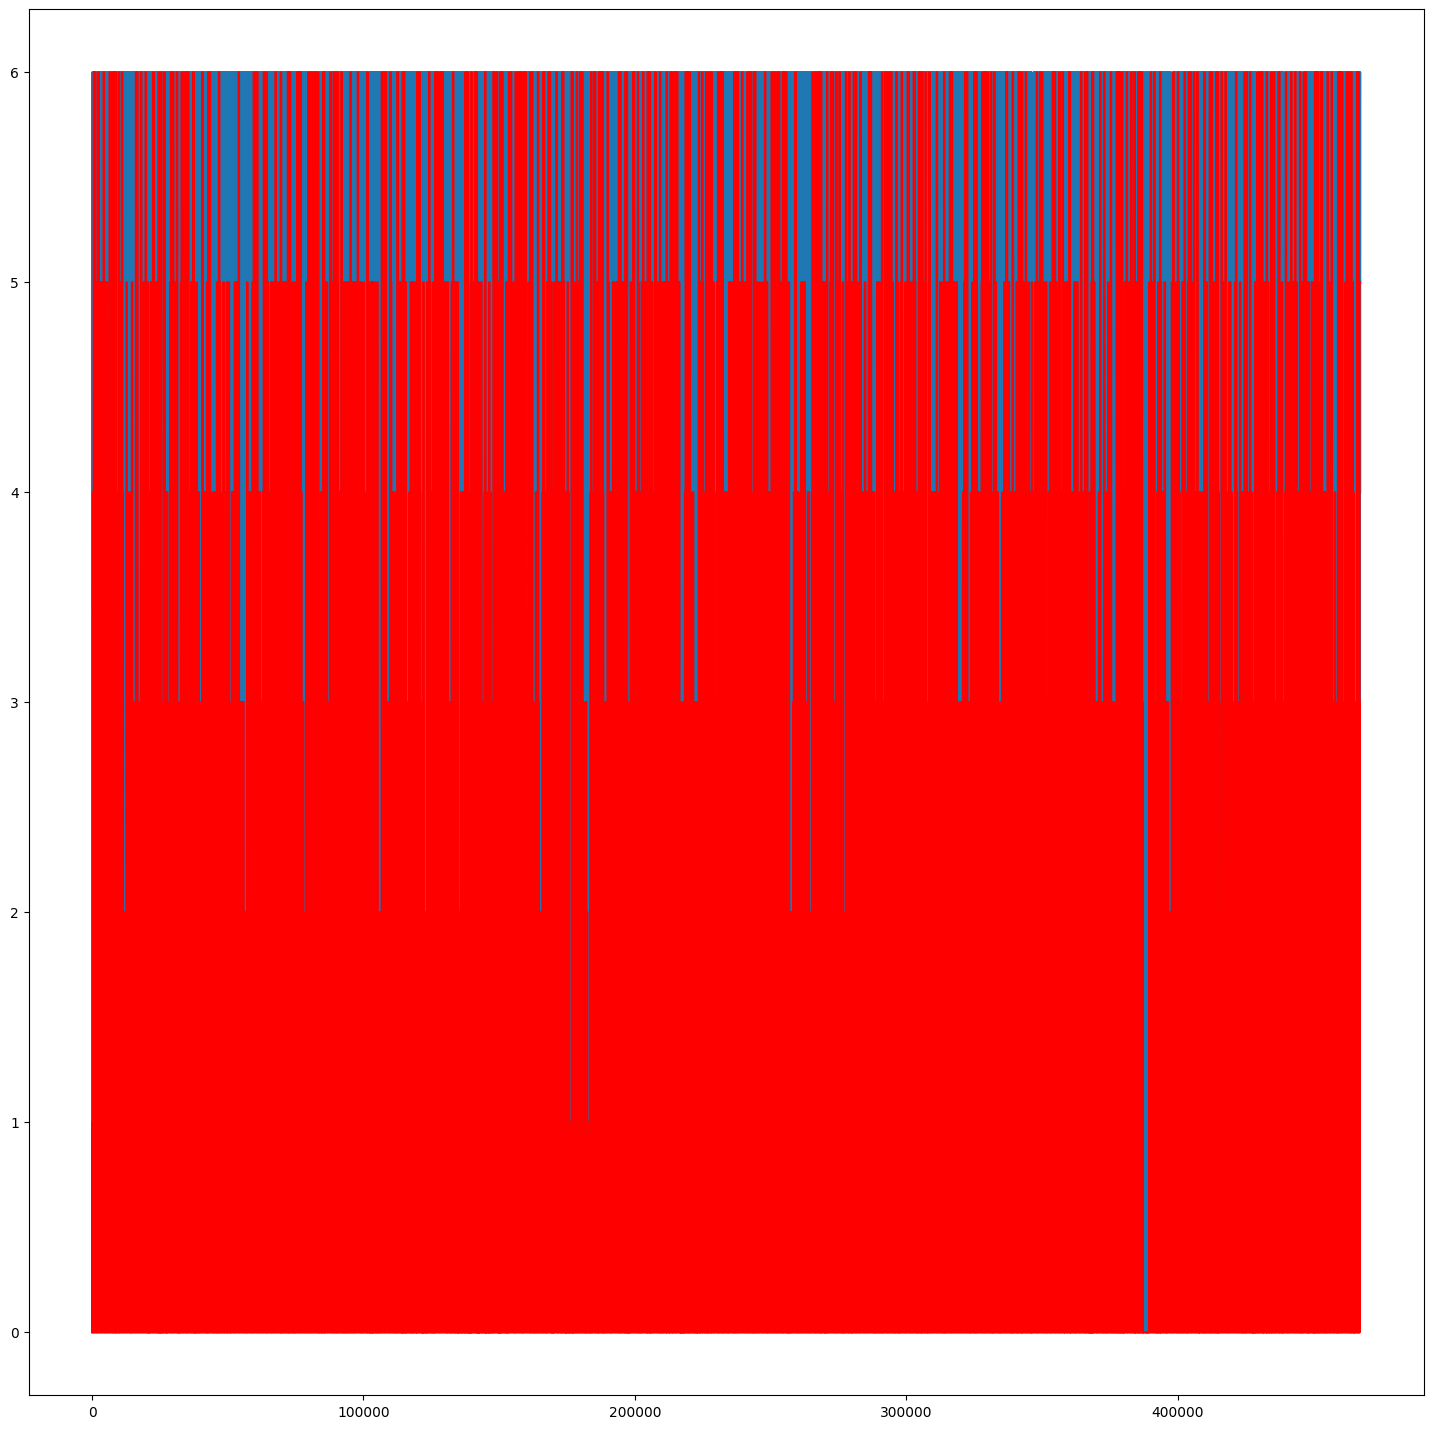

In [11]:
class_pred = []
for one_hot in prediction:
    idx = torch.argmax(one_hot)
    class_pred.append(idx.cpu())



plt.figure(figsize=(18, 18))
plt.plot(range(len(class_pred)), class_pred)
plt.plot(range(len(df['Marker'])), df['Marker'], color='red')

In [12]:
acc = sum(df['Marker'].values == class_pred) / len(df['Marker'])
print(acc)

0.48983410039601843


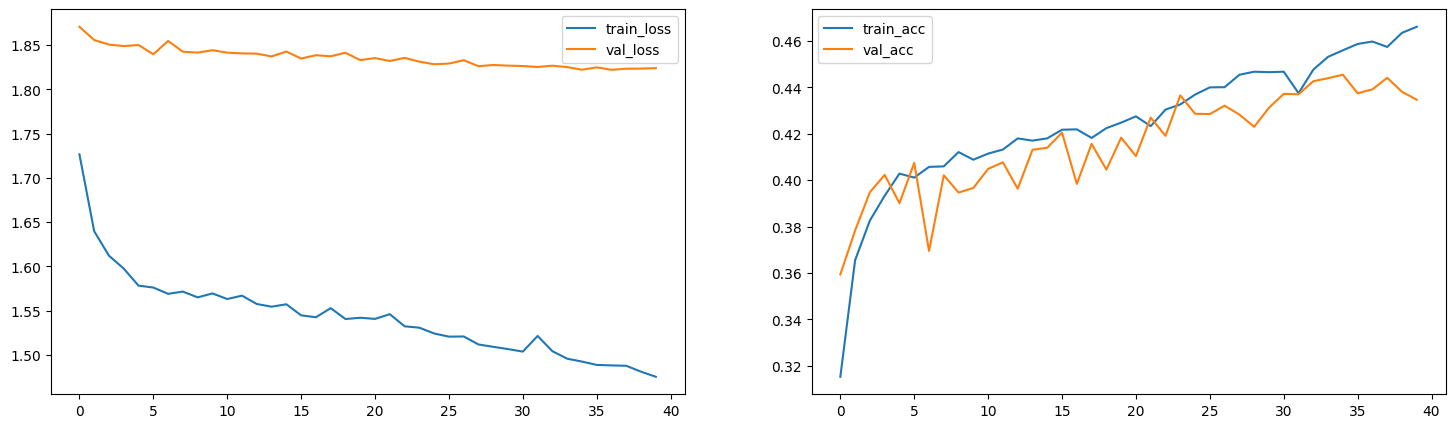

In [13]:
epoch_data = train_log.get('epochs', [])

val_loss = []
val_acc = []
train_loss = []
train_acc = []

for epoch_log in epoch_data:
    val_loss.append(epoch_log['val']['loss'])
    val_acc.append(epoch_log['val']['acc'])
    train_loss.append(epoch_log['train']['loss'])
    train_acc.append(epoch_log['train']['acc'])

num_epochs = range(len(epoch_data))

plt.figure(figsize=(18, 5))
plt.subplot(121)
plt.plot(num_epochs, train_loss, label='train_loss')
plt.plot(num_epochs, val_loss, label='val_loss')
plt.legend()
plt.subplot(122)
plt.plot(num_epochs, train_acc, label='train_acc')
plt.plot(num_epochs, val_acc, label='val_acc')
plt.legend()